<a href="https://colab.research.google.com/github/ammarisme/covid-19/blob/master/CV19_result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from functools import reduce
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on '+ ("GPU" if torch.cuda.is_available() else "CPU"))

running on CPU


In [11]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/covid'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#os.remove(INPUT_ROOT+"/processed/pre_transform.pt")
#os.remove(INPUT_ROOT+"/processed/processed.dt")
#os.remove(INPUT_ROOT+"/processed/pre_filter.pt")
#test dataset and loader
input_sequence_len = 5
output_sequence_len = 5
feature_length = 8
output_size = 2
INPUT_ROOT = PATH+'/input/training'
DATA_TAG = "seq2seq_5_5"
PROCESSED_DIR = '/processed_'+DATA_TAG

In [0]:

def loss_file_search(mypath):
  losses_files = [f for f in listdir(mypath) if ("losses" in f)]
  for loss_file in losses_files:
    losses = np.load(join(mypath, loss_file), allow_pickle=True)
    training_loss = np.array(losses.tolist()['losses']).T[0]
    plt.plot(training_loss)
    #loss_analysis(losses)
  
  directories = [f for f in listdir(mypath) if os.path.isdir(join(mypath, f))]
  for directory in directories:
    loss_file_search(mypath+'/'+directory)

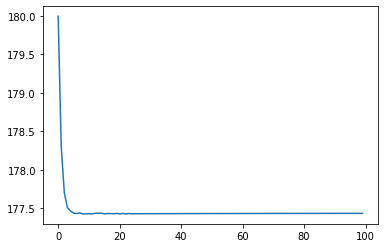

In [125]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim

root = PATH+'/models__rnn/run4'
#ylim(top=5.08, bottom=5.07)#, ylim_bottom=5.0
loss_file_search(root)

In [0]:
def loss_analysis(losses):
 print('loss analysis') 

['CV19 Cleaning.ipynb',
 'CV19_Synthesis.ipynb',
 '_Common.ipynb',
 'common (1).py',
 'common.py',
 'CV19Net.ipynb',
 'rnn_model_configurations_1001_443838.csv',
 'rnn_model_configurations_1001_165567.csv',
 'rnn_model_configurations_1001_353166.csv',
 'rnn_model_configurations_1001_57460.csv',
 'rnn_model_configurations_1001_981028.csv',
 'CV19 Dataset Explore.ipynb',
 'CV19_Dataset.ipynb',
 'RNN-CV19Net.ipynb',
 'CV19-result-analysis.ipynb']